In [29]:
import yfinance as yf
import pandas as pd
import numpy as np

In [52]:
data = yf.download("SPY", start="2010-05-01", end="2020-10-04")
data.to_csv("spy.csv")

[*********************100%***********************]  1 of 1 completed


In [53]:
spy_df = pd.read_csv("spy.csv", index_col = "Date", infer_datetime_format=True, parse_dates=True)


In [54]:
adj_close = spy_df["Adj Close"]
returns = adj_close.pct_change().dropna()
returns_neg = returns.loc[returns<0]
df = pd.concat([returns, returns_neg], axis="columns")
df = df.replace(np.NaN, value=0)
df.columns = ["Returns", "Downside Returns"]
df["Downside Deviation"] = df["Downside Returns"].rolling(30).std()
df = df.dropna()
df = df.drop(columns="Downside Returns")
df = df["Returns"]

In [55]:
def window_data(df, window, feature_col_number, target_col_number):
    """
    This function accepts the column number for the features (X) and the target (y).
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    """
    X = []
    y = []
    for i in range(len(df) - window):
        features = df.iloc[i : (i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

X, y = window_data(pd.DataFrame(adj_close), 5, 0, 0)

In [56]:
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

In [57]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [58]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print (f"X_train sample values:\n{X_train[:5]} \n")
print (f"X_test sample values:\n{X_test[:5]}") 

X_train sample values:
[[[0.05243124]
  [0.04403102]
  [0.04195314]
  [0.03043622]
  [0.02544945]]

 [[0.04403102]
  [0.04195314]
  [0.03043622]
  [0.02544945]
  [0.03999409]]

 [[0.04195314]
  [0.03043622]
  [0.02544945]
  [0.03999409]
  [0.03901453]]

 [[0.03043622]
  [0.02544945]
  [0.03999409]
  [0.03901453]
  [0.04382311]]

 [[0.02544945]
  [0.03999409]
  [0.03901453]
  [0.04382311]
  [0.03948947]]] 

X_test sample values:
[[[0.53561074]
  [0.54394196]
  [0.5438387 ]
  [0.54531889]
  [0.5320649 ]]

 [[0.54394196]
  [0.5438387 ]
  [0.54531889]
  [0.5320649 ]
  [0.53075683]]

 [[0.5438387 ]
  [0.54531889]
  [0.5320649 ]
  [0.53075683]
  [0.53141086]]

 [[0.54531889]
  [0.5320649 ]
  [0.53075683]
  [0.53141086]
  [0.54015502]]

 [[0.5320649 ]
  [0.53075683]
  [0.53141086]
  [0.54015502]
  [0.5371255 ]]]


In [59]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout 

In [63]:
model = Sequential()

number_units = 5
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=False,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))
# Layer 2
# model.add(LSTM(units=number_units, return_sequences=True))
# model.add(Dropout(dropout_fraction))
# Layer 3
# model.add(LSTM(units=number_units))
# model.add(Dropout(dropout_fraction))
# Output layer
model.add(Dense(1)) 

In [64]:
model.compile(optimizer="adam", loss="mean_squared_error") 
model.summary() 

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 5)                 140       
_________________________________________________________________
dropout_6 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 146
Trainable params: 146
Non-trainable params: 0
_________________________________________________________________


In [65]:
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=1, verbose=1) 

Epoch 1/10
1833/1833 [==============================] - 14s 5ms/step - loss: 4.1110e-04
Epoch 2/10
1833/1833 [==============================] - 7s 4ms/step - loss: 0.0028
Epoch 3/10
1833/1833 [==============================] - 8s 4ms/step - loss: 0.0020
Epoch 4/10
1833/1833 [==============================] - 9s 5ms/step - loss: 0.0015
Epoch 5/10
1833/1833 [==============================] - 9s 5ms/step - loss: 0.0012
Epoch 6/10
1833/1833 [==============================] - 8s 5ms/step - loss: 0.0011
Epoch 7/10
1833/1833 [==============================] - 8s 4ms/step - loss: 0.0012
Epoch 8/10
1833/1833 [==============================] - 9s 5ms/step - loss: 0.0012
Epoch 9/10
1833/1833 [==============================] - 9s 5ms/step - loss: 0.0012
Epoch 10/10
1833/1833 [==============================] - 9s 5ms/step - loss: 0.0012


In [66]:
model.evaluate(X_test, y_test) 

25/25 [==============================] - 1s 3ms/step - loss: 0.0154


0.015390459448099136

In [67]:
predicted = model.predict(X_test) 
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1)) 

In [69]:
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
    }, index = df.index[-len(real_prices): ])
stocks.head()

,Real,Predicted
Date,,
2017-08-18,225.699493,226.817917
2017-08-21,225.876160,226.276337
2017-08-22,228.238113,226.024567
2017-08-23,227.419785,226.483414
2017-08-24,226.889771,226.608963


<AxesSubplot:xlabel='Date'>

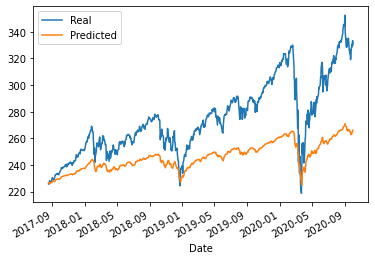

In [70]:
%matplotlib inline
stocks.plot()